In [187]:
import pandas as pd
import numpy as np
import pickle
import os

from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error

In [188]:
df = pd.read_csv('../data/serieA_matches.csv')
df_all_matches = pd.read_csv('../data/2020_all_matches.csv')

In [189]:
%%time

home_teams = df_all_matches[['Home', 'Venue']].drop_duplicates().values
team_stadium = {}
for data in home_teams:
     team_stadium[data[0]] = data[1]

CPU times: user 4.31 ms, sys: 6 µs, total: 4.32 ms
Wall time: 4.1 ms


In [190]:
%%time

team_dict = {}
for idx, team in enumerate(df['team'].unique()):
    team_dict[team] = idx

CPU times: user 3.07 ms, sys: 59 µs, total: 3.13 ms
Wall time: 2.58 ms


In [191]:
df['is_home'] = team_stadium[df['team'].iloc[0]]
df['is_home'] = df['stadium'] == df['is_home']
df['is_home'] = df['is_home'].astype(int)

In [192]:
cols_types = df.dtypes
cols_types[cols_types == object]

team       object
result     object
stadium    object
state      object
UF         object
date       object
time       object
dtype: object

In [193]:
df['time'] = df['time'].apply(lambda time: time.split(':')[0]).astype(int)

In [194]:
cols_to_remove = [
    'result',
    "date",
    "stadium",
    "state",
    "UF",
]
y_col = 'score'

In [195]:
df.drop(columns=cols_to_remove, inplace=True)

In [196]:
feature_cols = [col for col in df.columns if col not in cols_to_remove]

In [197]:
df_home_teams = pd.DataFrame()
df_adversary_teams = pd.DataFrame()

df_teams = pd.DataFrame()
for team in df['team'].unique():
    cols_to_drop = ['is_home', 'team', 'score']
    unique_cols = ['match_id', 'matchweek', 'time', 'year']
    
    df_team = df[df['team'] == team].copy().reset_index(drop=True)
    df_others_teams = df[
        (df['team'] != team) &
        (df['match_id'].isin(df_team['match_id'].tolist()))
    ].copy().reset_index(drop=True)
    
    columns = [col for col in df_team if col not in cols_to_drop]
    df_team.loc[df_team.index >= 3, columns] = (
        df_team[columns]
        .shift(1)
        .rolling(3)
        .mean()
        .iloc[3:]
    )

    df_others_teams.loc[df_others_teams.index >= 3, columns] = (
        df_team[columns]
        .shift(1)
        .rolling(3)
        .mean()
        .iloc[3:]
    )

    df_others_teams.drop(columns=cols_to_drop, inplace=True)
    df_others_teams.columns = [
        col + '_adversary' if col not in unique_cols else col for col in df_others_teams.columns
    ]
    
    for col in [column for column in df_others_teams.columns if column.endswith('adversary')]:
        df_team[col] = df_others_teams[col]

In [198]:
df_teams = df_team

In [199]:
df_teams = df_teams[~df_teams['team'].isna()].copy()

In [200]:
df_teams['team'] = df_teams['team'].apply(lambda team: team_dict[team])

In [201]:
df_teams['score'].fillna(-1, inplace=True)
df_teams = df_teams[df_teams['score'] != -1]
df_teams['score'] = df_teams['score'].astype(int)

In [202]:
X = df_teams.drop(columns=['score'])
Y = df_teams['score']

In [203]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    difference = list(np.abs((y_true - y_pred) / y_true))
    difference = [diff if diff != np.inf and not pd.isnull(diff) else 0 for diff in difference]
    return np.mean(difference)


In [204]:
def bias_percentage(y_true, y_pred): 
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    return  np.sum(y_pred) / np.sum(y_true)

In [205]:
X.sort_values(['matchweek', 'team', 'year'], inplace=True)
X_new = X

In [206]:
n_cols = 50

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X_new, Y, test_size=0.1, random_state=7)

In [208]:
from sklearn.metrics import mean_absolute_error

model = XGBRegressor()

model.fit(X_train, y_train)

y_pred = list(model.predict(X_test))
predictions = list([round(value) for value in y_pred])

# evaluate predictions
mape = mean_absolute_percentage_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
bias_percent = bias_percentage(y_test, predictions)

print("MAPE with {} columns: {:.2f}%".format(n_cols, mape * 100.0))
print("MAE with {} columns: {:.2f}".format(n_cols, mae))
print("BIAS% with {} columns: {:.2f}%".format(n_cols, bias_percent * 100))


MAPE with 50 columns: 12.50%
MAE with 50 columns: 0.17
BIAS% with 50 columns: 93.33%


<ipython-input-203-70d46a524b4a>:5: RuntimeWarning: invalid value encountered in true_divide
  difference = list(np.abs((y_true - y_pred) / y_true))


# ==================================================

In [209]:
match_per_round = df['matchweek'].value_counts().to_frame()
last_matchweek = match_per_round[match_per_round > 5].sort_values('matchweek', ascending=False).iloc[0].name

In [210]:
next_matches = df_all_matches

In [211]:
next_matches['Score'] = next_matches['Score'].fillna('')
next_matches = next_matches[next_matches['Score'] == '']
next_matches['Wk'] = next_matches['Wk'].fillna('')
next_matches = next_matches[next_matches['Wk'] != '']
next_matches = next_matches[next_matches['Wk'] > last_matchweek]

<ipython-input-211-4b5007b19b6a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  next_matches['Wk'] = next_matches['Wk'].fillna('')


In [212]:
last_match_id = df[df['year'] == 2020]['match_id'].max()

In [213]:
def make_dataset(interested_team, other_team, cols):
    cols_to_use = [col for col in interested_team.columns if 'adversary' not in col]
    
    interested_team = interested_team[cols_to_use]
    other_team = other_team[cols_to_use]
    
    other_team.columns = [col + '_adversary' if col not in ['result', 'match_id'] else col for col in interested_team.columns ]
    
    df = interested_team.merge(other_team, on='match_id')

    return df[cols]
    

In [214]:
next_matchweek = df_teams['matchweek'].max() + 1

In [215]:
if os.path.exists('../data/predictions.csv'):
    predictions = pd.read_csv('../data/predictions.csv').reset_index(drop=True)
else:
    predictions = pd.DataFrame()

In [216]:
for next_match in next_matches.iterrows():
    try:
        next_match = next_match[1].to_frame().transpose()
        team1, team2 = next_match[['Home', 'Away']].iloc[0]
        date = pd.to_datetime(next_match['Date'].iloc[0])
        if next_match['Time'].iloc[0] is not np.nan:
            time = int(next_match['Time'].iloc[0].split(':')[0])
        else:
            time = np.nan
            
        matchweek = int(next_match['Wk'].iloc[0])

        if team1 not in team_dict.keys():
            team_dict[team1] = max(team_dict.values()) + 1

        if team2 not in team_dict.keys():
            team_dict[team2] = max(team_dict.values()) + 1

        if matchweek == next_matchweek:
            cols = X_new.columns.tolist()
            mean_features_team1 = df[(df['team'] == team1) & (df['year'] == 2020)].copy()
            mean_features_team2 = df[(df['team'] == team2) & (df['year'] == 2020)].copy()

            mean_features_team1['match_id'] = last_match_id + 1
            mean_features_team2['match_id'] = last_match_id + 1
            
            mean_features_team1['time'] = mean_features_team1['time'].fillna(method='ffill')
            mean_features_team2['time'] = mean_features_team2['time'].fillna(method='ffill')
            
            mean_features_team1['matchweek'] = int(matchweek)
            mean_features_team2['matchweek'] = int(matchweek)

            for col in df.columns:
                if df[col].dtype != object and col not in ['score', 'match_id']:
                    mean_features_team1[col] = mean_features_team1[col].shift(1).rolling(window=3).mean().copy()
                    mean_features_team2[col] = mean_features_team2[col].shift(1).rolling(window=3).mean().copy()

            mean_features_team1 = mean_features_team1.iloc[-1:].copy()
            mean_features_team2 = mean_features_team2.iloc[-1:].copy()

            mean_features_team1['is_home'] = 1
            mean_features_team2['is_home'] = 0

            mean_features_team1['team'] = team_dict[team1]
            mean_features_team2['team'] = team_dict[team2]

            dataset_team1 = make_dataset(mean_features_team1, mean_features_team2, cols).round(2)
            dataset_team2 = make_dataset(mean_features_team2, mean_features_team1, cols).round(2)

            game_prediction = dataset_team1.append(dataset_team2)
            prediction = [round(prediction) for prediction in list(model.predict(game_prediction))]
            print(f"Rodada {matchweek}: {team1} {prediction[0]} x {prediction[1]} {team2}!")
            last_match_id += 1

            predictions = predictions.append(pd.DataFrame({
                'matchweek': [matchweek],
                'team1': [team1],
                'score_team1': [prediction[0]],
                'team2': [team2],
                'score_team2': [prediction[1]],
            }))
            
    except Exception as e:
        print(e)
        pass

Rodada 16: Vasco da Gama 2 x 0 Fortaleza!
Rodada 16: Ceará 2 x 0 São Paulo!
Rodada 16: Palmeiras 1 x 1 Coritiba!
Rodada 16: Grêmio 2 x 2 Botafogo (RJ)!
Rodada 16: Santos 2 x 1 Atl Goianiense!
Rodada 16: Atlético Mineiro 2 x 0 Fluminense!
Rodada 16: Sport Recife 0 x 1 Internacional!
Rodada 16: Atl Paranaense 1 x 1 Corinthians!
Rodada 16: Flamengo 0 x 2 Bragantino!
Rodada 16: Goiás 1 x 2 Bahia!


In [217]:
# if predictions[predictions['matchweek'] == matchweek].shape[0] <= 10:
predictions.reset_index(drop=True).to_csv('../data/predictions.csv', index=False)

with open('../data/serial/xgboost_regressor.model', 'wb') as serial_model:
    pickle.dump(model, serial_model)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

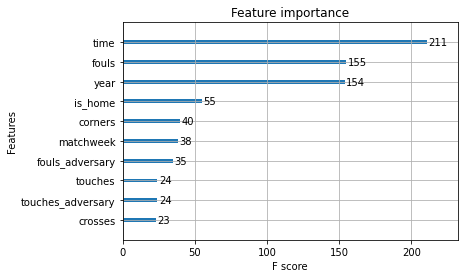

In [218]:
from xgboost import plot_importance
plot_importance(model, max_num_features=10)